In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tarfile
import urllib.request
from zlib import crc32

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

I wrote a function to download and save the dataset.

In [3]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

Now the data is ready.

In [4]:
housing = load_housing_data()

### Getting familiar with the dataset.

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There is a categorical attribute and null values in the data.

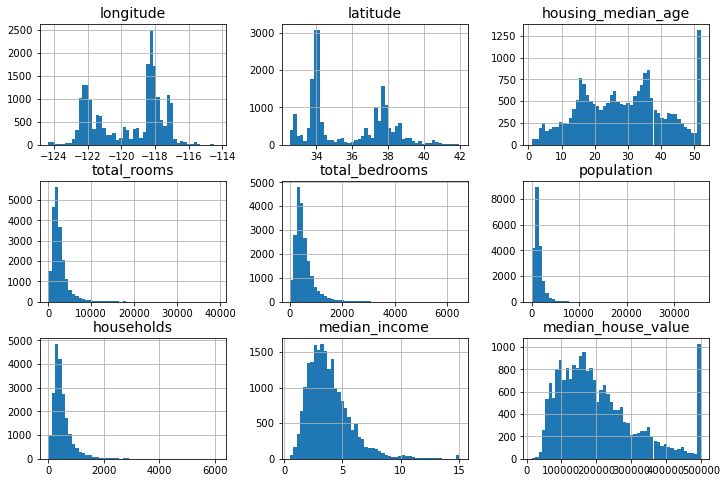

In [8]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show() 

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Creating Test set

To avoid having a skewed dataset, I use stratified sampling based on median income category.

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                              labels=[1, 2, 3, 4, 5])

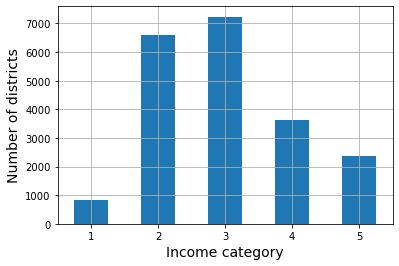

In [11]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [12]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

I won't use income_cat column again.

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualization data.

In [14]:
housing = strat_train_set.copy()

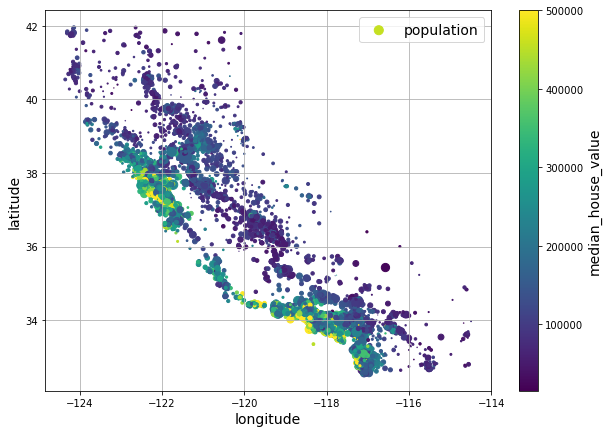

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

This image tells us that the housing prices are very much related to the
location and to the population density.

#### Looking for the correlations.

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_13476/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

It seems like the most promising attribure to predict the median house value is the median income.
Also total number of rooms in a district is not very useful if you don't
know many households there are.
So I use a few attribute combinations and then check the correlation again.

In [16]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [17]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_5647/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The new bedrooms_ratio attribute is much more correlated
with the median house value than the total number of rooms or bedrooms.
Apparently houses with a lower bedroom/room ratio tend to be more
expensive.

### Preparing data for machine learning algorithm.

In [18]:
housing_labels = strat_train_set["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3.725256,0.277371,1.631399
...,...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN,4.277247,0.266875,1.793499
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND,5.535714,0.201019,2.667293
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN,5.157895,0.197704,3.702632
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN,4.511933,0.230891,2.058473


### Cleaning the data.

In [19]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


I used Kmeans clustering to identify the main clusters in the training data using fit() method and finds similarity with the rbf kernel
in the transform method().

In [22]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)

In [23]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [24]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)

In [40]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 27)

In [41]:
df_housing_prepared = pd.DataFrame(housing_prepared,
                                      columns=preprocessing.get_feature_names_out(),
                                       index=housing.index)

In [42]:
df_housing_prepared

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age,remainder__rooms_per_house,remainder__bedrooms_ratio,remainder__people_per_house
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,3.788947e-18,1.319640e-01,...,5.824761e-01,0.0,0.0,0.0,1.0,0.0,1.861119,-0.866027,2.153743,-0.330204
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,3.346712e-01,1.735776e-09,...,2.078829e-10,1.0,0.0,0.0,0.0,0.0,0.907630,0.024550,-0.569651,-0.253616
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.874903e-18,2.749482e-01,...,2.896858e-01,0.0,1.0,0.0,0.0,0.0,0.351428,-0.041193,-0.215784,-0.051041
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,8.832834e-01,2.237307e-14,...,3.778950e-16,0.0,1.0,0.0,0.0,0.0,-0.919891,-0.034858,-0.154314,-0.141475
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,4.893551e-01,2.891966e-11,...,3.361020e-12,0.0,0.0,0.0,0.0,1.0,0.589800,-0.666554,1.132023,-0.306148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,3.180854e-01,2.306753e-10,...,3.886016e-11,1.0,0.0,0.0,0.0,0.0,0.987087,-0.452111,0.948316,-0.269780
13105,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.025197e-04,6.690741e-03,...,4.309336e-04,0.0,1.0,0.0,0.0,0.0,-0.443146,0.036792,-0.204419,-0.073741
19301,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,1.209845e-01,3.347757e-19,...,1.811644e-20,0.0,0.0,0.0,0.0,1.0,-1.237721,-0.109987,-0.262436,0.158542
19121,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,3.252711e-01,1.067490e-09,...,1.447641e-10,1.0,0.0,0.0,0.0,0.0,0.669257,-0.360937,0.318463,-0.210332


### Data is ready to be trained.

In [43]:
forest_reg = make_pipeline(preprocessing,
                          RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [44]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47032.384109
std       1003.082277
min      45631.245160
25%      46523.830991
50%      46915.636751
75%      47292.615527
max      49273.936990
dtype: float64

In [45]:
from sklearn.metrics import mean_squared_error

forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions,
                                 squared=False)
forest_rmse

17487.168932031687

RMSE is lower on the training set than validation set, meaning that there's quite a lot of overfitting going on.

I need to fine tune our models hyperparameters.

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

full_pipeline = Pipeline([
("preprocessing", preprocessing),
("random_forest", RandomForestRegressor(random_state=42)),
])

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7fad32312560>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fad322b8430>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fad328e88e0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [47]:
final_model = rnd_search.best_estimator_  
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.05, 0.04, 0.04, 0.01, 0.01, 0.01, 0.01, 0.17, 0.03, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.03,
       0.01, 0.  , 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01, 0.03, 0.04, 0.04])

In [48]:
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.17299362588757775, 'log__median_income'),
 (0.07178279317535693, 'cat__ocean_proximity_INLAND'),
 (0.0475364554740168, 'bedrooms__ratio'),
 (0.0440463559178761, 'remainder__bedrooms_ratio'),
 (0.03890137453909414, 'remainder__people_per_house'),
 (0.03873884862740817, 'rooms_per_house__ratio'),
 (0.03745556199524362, 'people_per_house__ratio'),
 (0.033701831323062016, 'remainder__rooms_per_house'),
 (0.02764508381891734, 'geo__Cluster 0 similarity'),
 (0.027135302816704197, 'geo__Cluster 24 similarity'),
 (0.020101133918495814, 'geo__Cluster 28 similarity'),
 (0.019351504923992888, 'geo__Cluster 20 similarity'),
 (0.01750482042190248, 'geo__Cluster 43 similarity'),
 (0.01721304827935808, 'geo__Cluster 34 similarity'),
 (0.016988843054203413, 'geo__Cluster 27 similarity'),
 (0.014359999810498356, 'geo__Cluster 37 similarity'),
 (0.014255033575561508, 'geo__Cluster 38 similarity'),
 (0.01347044103128443, 'geo__Cluster 4 similarity'),
 (0.013046468986104754, 'geo__Cluster 3 similarity

There are less useful features, so it is possible to drop them and train the model again.

In [49]:
df_housing_prepared = df_housing_prepared.drop(["log__total_rooms", "log__population", "log__total_bedrooms",
                                               "log__households"], axis=1)

In [50]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test["rooms_per_house"] = X_test["total_rooms"] / X_test["households"]
X_test["bedrooms_ratio"] = X_test["total_bedrooms"] / X_test["total_rooms"]
X_test["people_per_house"] = X_test["population"] / X_test["households"]

In [51]:
from sklearn.metrics import mean_squared_error

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41856.975155187145


Let's see how precise this estimate is with a 95% confidence interval for the generalization error.

In [52]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39721.34170624, 43888.81123179])

I have trained different models using SVM and DecisionTree and linear Regression. Also I have created a custom transformer that trains a k_nearest neighbors regressor(sklearn.neighbors.KNeighborsRegressor) instead of Kmeans clustering for the longtitude and latitude but the results were so bad. I commented the code so you can try it yourself.

In [53]:
# ###
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.base import MetaEstimatorMixin, clone

# class FeatureFromRegressor(MetaEstimatorMixin, BaseEstimator, TransformerMixin):
#     def __init__(self, estimator):
#         self.estimator = estimator

#     def fit(self, X, y=None):
#         estimator_ = clone(self.estimator)
#         estimator_.fit(X, y)
#         self.estimator_ = estimator_
#         self.n_features_in_ = self.estimator_.n_features_in_
#         if hasattr(self.estimator, "feature_names_in_"):
#             self.feature_names_in_ = self.estimator.feature_names_in_
#         return self  # always return self!
    
#     def transform(self, X):
#         check_is_fitted(self)
#         predictions = self.estimator_.predict(X)
#         if predictions.ndim == 1:
#             predictions = predictions.reshape(-1, 1)
#         return predictions

#     def get_feature_names_out(self, names=None):
#         check_is_fitted(self)
#         n_outputs = getattr(self.estimator_, "n_outputs_", 1)
#         estimator_class_name = self.estimator_.__class__.__name__
#         estimator_short_name = estimator_class_name.lower().replace("_", "")
#         return [f"{estimator_short_name}_prediction_{i}"
#                 for i in range(n_outputs)]
# ###

You can check if it compiles to the sikit-learn's API using the following code.

In [66]:
# from sklearn.utils.estimator_checks import check_estimator

# check_estimator(FeatureFromRegressor(KNeighborsRegressor()))